#**AZATIK BATIK MOTIF CLASSIFICATION (without transfer learning)**

## Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/data/Azatik-Dataset2.zip

Archive:  gdrive/My Drive/data/Azatik-Dataset2.zip
   creating: Azatik-Dataset/
   creating: Azatik-Dataset/Celup/
  inflating: Azatik-Dataset/Celup/1.jpg  
  inflating: Azatik-Dataset/Celup/10.jpg  
  inflating: Azatik-Dataset/Celup/11.jpg  
  inflating: Azatik-Dataset/Celup/12.jpg  
  inflating: Azatik-Dataset/Celup/13.jpg  
  inflating: Azatik-Dataset/Celup/14.jpg  
  inflating: Azatik-Dataset/Celup/15.jpg  
  inflating: Azatik-Dataset/Celup/16.jpg  
  inflating: Azatik-Dataset/Celup/17.jpg  
  inflating: Azatik-Dataset/Celup/18.jpg  
  inflating: Azatik-Dataset/Celup/19.jpg  
  inflating: Azatik-Dataset/Celup/2.jpg  
  inflating: Azatik-Dataset/Celup/20.jpg  
  inflating: Azatik-Dataset/Celup/21.jpg  
  inflating: Azatik-Dataset/Celup/22.jpg  
  inflating: Azatik-Dataset/Celup/23.jpg  
  inflating: Azatik-Dataset/Celup/24.jpg  
  inflating: Azatik-Dataset/Celup/25.jpg  
  inflating: Azatik-Dataset/Celup/26.jpg  
  inflating: Azatik-Dataset/Celup/27.jpg  
  inflating: Azatik-Dataset

In [ ]:
#import library
import os
import random
import numpy as np
import tensorflow as tf
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from pathlib import Path
import imghdr
import matplotlib.pyplot as plt
from matplotlib import style
from tensorflow.compat.v1.keras.backend import backend as K
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Activation
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras_preprocessing import image
import zipfile
from tensorflow.keras import layers
from tensorflow.keras import Model


In [ ]:
#source path folder to dataset and making labels
source_path = 'Azatik-Dataset/' 
labels = ['Tambal', 'Parang','Kawung','Celup','Cendrawasih']

#the split ratio
val_ratio = 0.15
test_ratio = 0.05

#path to directory
root_path = 'traintestval/'

#make directory for split dataset
os.makedirs('traintestval')
os.makedirs(os.path.join(root_path, 'training'))
os.makedirs(os.path.join(root_path, 'testing'))
os.makedirs(os.path.join(root_path, 'validation'))

#path to dataset after split
train_path = 'traintestval/training/'
test_path = 'traintestval/testing/'
val_path = 'traintestval/validation/'

#assigning label
for label in labels:
    os.makedirs(os.path.join(train_path, label))
    os.makedirs(os.path.join(test_path, label))
    os.makedirs(os.path.join(val_path, label))

#Splitting the dataset
    src = source_path + label 
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    for name in train_FileNames:
          shutil.copy(name, train_path + label)

    for name in val_FileNames:
          shutil.copy(name, val_path + label)

    for name in test_FileNames:

In [ ]:
source_path = 'Azatik-Dataset/'
from pathlib import Path
import imghdr

#checking file type
image_extensions = [".png", ".jpg"]  

#making sure its accepted by tensorflow
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(source_path).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32, 
                                                      class_mode='categorical',
                                                      target_size=(150, 150))


  validation_datagen = ImageDataGenerator( rescale = 1/255 )

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32, 
                                                                class_mode='categorical',
                                                                target_size=(150, 150),
                                                                shuffle=True)

  return train_generator, validation_generator

In [ ]:
#checking class and number of image
train_dir = train_path
validation_dir = val_path 
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 359 images belonging to 5 classes.
Found 67 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(150, 150))

Found 359 files belonging to 5 classes.


In [ ]:
class_names = train_dataset.class_names

print(class_names)

['Celup', 'Cendrawasih', 'Kawung', 'Parang', 'Tambal']


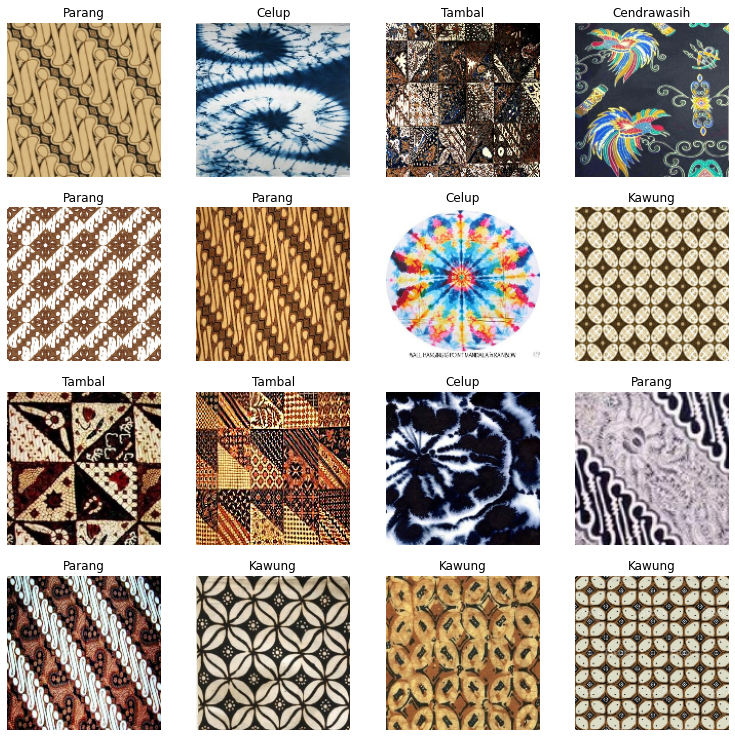

In [ ]:
#visualize the dataset
plt.figure(figsize=(13, 13))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model without transfer learning (Simple CNN)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv2D(filters = 64, kernel_size = (3,3),activation ='relu', input_shape = (150,150,3)))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Conv2D(filters = 256, kernel_size = (3,3),activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Conv2D(filters = 512, kernel_size = (3,3),activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(1024, Activation('relu')))

  model.add(Dropout(0.1))
  model.add(Dense(5, activation = "softmax"))

  model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

  return model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.keras.backend import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical

model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 256)      0

In [ ]:
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/20
12/12 [==============================] - 66s 5s/step - loss: 1.6322 - accuracy: 0.1699 - val_loss: 1.5831 - val_accuracy: 0.2537
Epoch 2/20
12/12 [==============================] - 63s 5s/step - loss: 1.5672 - accuracy: 0.2813 - val_loss: 1.5611 - val_accuracy: 0.2687
Epoch 3/20
12/12 [==============================] - 61s 5s/step - loss: 1.5101 - accuracy: 0.3148 - val_loss: 1.5256 - val_accuracy: 0.2836
Epoch 4/20
12/12 [==============================] - 60s 5s/step - loss: 1.4857 - accuracy: 0.3482 - val_loss: 1.4712 - val_accuracy: 0.3881
Epoch 5/20
12/12 [==============================] - 59s 5s/step - loss: 1.4290 - accuracy: 0.3705 - val_loss: 1.4435 - val_accuracy: 0.4030
Epoch 6/20
12/12 [==============================] - 59s 5s/step - loss: 1.4101 - accuracy: 0.3538 - val_loss: 1.4139 - val_accuracy: 0.3881
Epoch 7/20
12/12 [==============================] - 60s 5s/step - loss: 1.3496 - accuracy: 0.4345 - val_loss: 1.4258 - val_accuracy: 0.3731
Epoch 8/20
12/12 [==

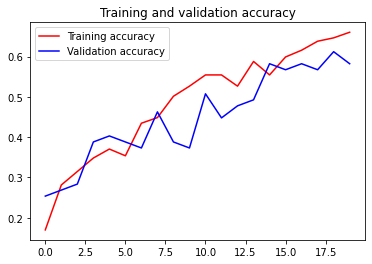

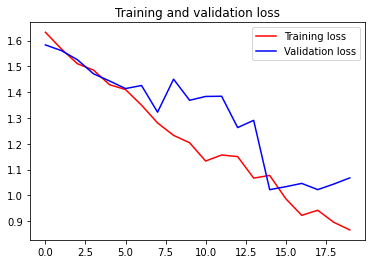

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()